# Density Module (Correlation Functions, Grain Detection)
The density module is intended to compute a variety of quantities associated with particle distributions with respect to other particles. This example shows how the Correlation functions can be used to approximate the grain size within a system.

In [1]:
import numpy as np
import freud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy.optimize import root

First, let's start with a clearly phase separated ising lattice and assign type values (either -1 or 1)

Based upon this set-up, we know that our grain radius will be $\frac{2 s(\ln{1+\sqrt{2}})}{\pi}$, where s is the sidelength of the square grain.

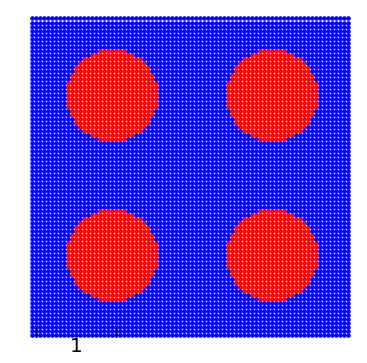

In [2]:
#Setup the system

size=4
dx=0.05
num_grains=2
dg=size/(num_grains)
points=np.array([[i,j,0] for j in np.arange(0,size,dx) for i in np.arange(0,size,dx)])
values=np.array([-1 for p in points])
centroids=[[i*dg +0.5*dg, j*dg +0.5*dg,0] for i in range(num_grains) for j in range(num_grains)]
rad=dg/3.5
for p in centroids:
    for k,pp in enumerate(points):
        if(sum([(p[i]-pp[i])**2.0 for i in range(2)])<=rad**2.0):
            values[k]=1

plt.figure(figsize=(6,6))
plt.scatter(points[values>0,:][:,0], points[values>0,:][:,1], marker='o', color='r', s=1000*dx/size)
plt.scatter(points[values<0,:][:,0], points[values<0,:][:,1], marker='o', color='b', s=1000*dx/size)

plt.plot([dx,1+dx],[-(size/10)*dx,-(size/10)*dx],c='k', marker="|",linewidth=size/10, markersize=20, zorder=1)
plt.text(x=0.5+dx, y=-1.1*(size/10)*dx, s='{}'.format(1), horizontalalignment='center', verticalalignment='top', fontsize=20, zorder=0)
plt.gca().set_aspect('equal')
plt.gca().set_xlim([-(size/10)*dx,size+dx])
plt.gca().set_ylim([-(size/10)*dx,size+dx])
plt.axis('off')
plt.show()

Let's first find the clusters.

In [3]:
box = freud.box.Box.square(L=size)
cl = freud.cluster.Cluster(box=box, rcut=size/5.)
cluster_idx = cl.computeClusters(points[values>0,:]).cluster_idx

Now we'll find each cluster centroid

In [4]:
clp = freud.cluster.ClusterProperties(box=box)
clp.computeProperties(points[values>0,:], cl.cluster_idx)

Now we create a box and a density compute object.

In [5]:
fcf = freud.density.FloatCF(rmax=size/4., dr=dx/2.)
fcf.resetCorrelationFunction()

Now we compute the product of type values. Knowing that two sites with the same type will have a product of 1, we can estimate the radius of a grain as $r_{PCF}=0$. We will only calculate the radii of the red type.

The expected grain size is of Cluster 0 is 0.571. Real radius is 0.5750906765460968
The expected grain size is of Cluster 1 is 0.571. Real radius is 0.5750906765460968
The expected grain size is of Cluster 2 is 0.571. Real radius is 0.5750906765460968
The expected grain size is of Cluster 3 is 0.571. Real radius is 0.5750906765460968
Overall average is 0.5751


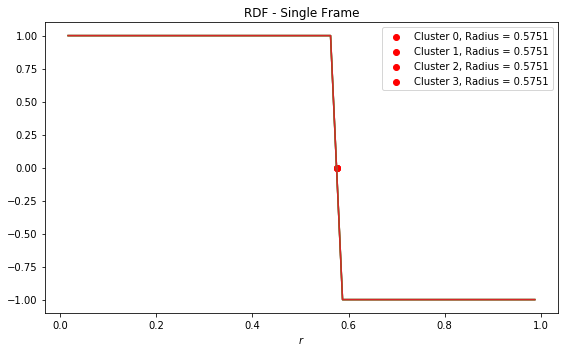

In [6]:
plt.figure(figsize=(8, 5))
weights=[]
sizes=[]
for cluster_id in range(cl.num_clusters):
    fcf.compute(box=box,             
                ref_points=points, #all points in the system
                refValues=values, #all types in the system
                points=[clp.cluster_COM[cluster_id]],
                values=[1])
    # get the center of the histogram bins
    r = fcf.getR()
    # get the value of the histogram bins
    y = fcf.getRDF()
    grainsize=y[y>0][-1]*(r[y<0][0]-r[y>0][-1])/(-y[y<0][0]+y[y>0][-1])+r[y>0][-1]
    print('The expected grain size is of Cluster {} is {}. Real radius is {}'.format(cluster_id, round(rad,3), grainsize))

    plt.plot(r,y)
    plt.scatter(x=grainsize, y=0,c='r', label='Cluster {}, Radius = {}'.format(cluster_id, round(grainsize,4)))

    weights.append(len(np.where(cluster_idx == cluster_id)[0]))
    sizes.append(grainsize)
    
print('Overall average is {}'.format(round(sum([a*w for a,w in zip(sizes, weights)])/sum(weights),4)))
plt.title("RDF - Single Frame")
plt.xlabel(r"$r$")
plt.legend()
plt.tight_layout()
plt.show()

Now, let's setup a more complex system

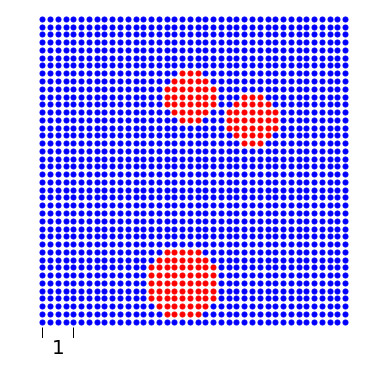

In [103]:
#Setup the system

size=10
dx=0.25
points=np.array([[i,j,0] for j in np.arange(0,size,dx) for i in np.arange(0,size,dx)])
values=np.array([-1 for p in points])
nclusters=0
while(nclusters<3):
    r=np.random.uniform(0,size/4.)
    
    p=np.random.choice([i for i,v in enumerate(values) if v<0])# and all([vv<0 for p,vv in zip(points, values) if sum([(points[i][x]-p[x])**2.0 for x in range(3)])<=(1.2*r)**2.0])])
    for k,pp in enumerate(points):
        if(sum([(points[p][i]-pp[i])**2.0 for i in range(3)])<=r**2.0):
            values[k]=1
    nclusters+=1
markers=['_' if v<0 else "+" for v in values]
plt.figure(figsize=(6,6))
plt.plot([0,1],[-(size/5)*dx,-(size/5)*dx],c='k', marker="|",linewidth=size/10, markersize=20, zorder=1)
plt.text(x=0.5, y=-1.1*(size/5)*dx, s='{}'.format(1), horizontalalignment='center', verticalalignment='top', fontsize=20, zorder=0)
plt.scatter(points[values>0,:][:,0], points[values>0,:][:,1], marker='o', color='r', s=1000/(size/dx), zorder=0)
plt.scatter(points[values<0,:][:,0], points[values<0,:][:,1], marker='o', color='b', s=1000/(size/dx), zorder=0)
plt.gca().set_aspect('equal')
plt.gca().set_xlim([-(size/5)*dx,size])
plt.gca().set_ylim([-(size/5)*dx,size])
plt.axis('off')
plt.show()

Now we create a box and a density compute object.

In [108]:
rcut=size/4.01
box = freud.box.Box.square(L=size)
cl = freud.cluster.Cluster(box=box, rcut=rcut)
cluster_idx = cl.computeClusters(points[values>0,:]).cluster_idx
while(len(set(cluster_idx))<=nclusters and rcut>dx):
    rcut-=0.01*dx
    cl = freud.cluster.Cluster(box=box, rcut=rcut)
    cluster_idx = cl.computeClusters(points[values>0,:]).cluster_idx
    if(rcut<0):
        break
if(len(set(cluster_idx))>100):
    print('Rerunning...')
    while(len(set(cluster_idx))<=1 and rcut>dx):
        rcut-=0.1*dx
        cl = freud.cluster.Cluster(box=box, rcut=rcut)
        cluster_idx = cl.computeClusters(points[values>0,:]).cluster_idx
        if(rcut<0):
            break    
if(len(set(cluster_idx))>100):
    print('Resetting...')
    rcut=size/4.01
    box = freud.box.Box.square(L=size)
    cl = freud.cluster.Cluster(box=box, rcut=rcut)
    cluster_idx = cl.computeClusters(points[values>0,:]).cluster_idx
print()
print(len(set(cluster_idx)))

Rerunning...
Resetting...

1


Now we'll find each cluster centroid

In [93]:
clp = freud.cluster.ClusterProperties(box=box)
clp.computeProperties(points[values>0,:], cl.cluster_idx)

Now we create a box and a density compute object.

In [94]:
fcf = freud.density.FloatCF(rmax=size/2., dr=dx/2.)
fcf.resetCorrelationFunction()

Now we compute the product of type values. Knowing that two sites with the same type will have a product of 1, we can estimate the radius of a grain as $r_{PCF}=0$. We will only calculate the radii of the red type.

Cluster 0 radius is 0.6554909358764517
Overall average is 0.6555


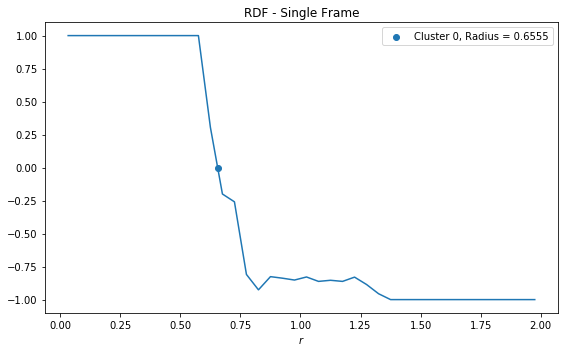

In [95]:
plt.figure(figsize=(8, 5))
weights=[]
sizes=[]
for cluster_id in range(cl.num_clusters):
    fcf.compute(box=box,             
                ref_points=points, #all points in the system
                refValues=values, #all types in the system
                points=[clp.cluster_COM[cluster_id]],
                values=[1])
    # get the center of the histogram bins
    r = fcf.getR()
    # get the value of the histogram bins
    y = fcf.getRDF()
    grainsize=y[y>0][-1]*(r[y<0][0]-r[y>0][-1])/(-y[y<0][0]+y[y>0][-1])+r[y>0][-1]
    print('Cluster {} radius is {}'.format(cluster_id, grainsize))

    plt.plot(r,y)
    plt.scatter(x=grainsize, y=0,label='Cluster {}, Radius = {}'.format(cluster_id, round(grainsize,4)))

    weights.append(len(np.where(cluster_idx == cluster_id)[0]))
    sizes.append(grainsize)
    
print('Overall average is {}'.format(round(sum([a*w for a,w in zip(sizes, weights)])/sum(weights),4)))
plt.title("RDF - Single Frame")
plt.xlabel(r"$r$")
plt.legend()
plt.tight_layout()
plt.show()